# Station Matching

The goal of this notebook is to identify stations that changed IDs. This has been known to occur for Maritime and ASOSOAWOS stations.


## Environment set-up

In [1]:
from shapely.geometry import Point
from shapely.ops import nearest_points

from functools import reduce
import datetime
from pandas import *
import boto3
import geopandas as gpd
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from io import BytesIO, StringIO

import tempfile  # Used for downloading (and then deleting) netcdfs to local drive from s3 bucket

import s3fs

# import tempfile  # Used for downloading (and then deleting) netcdfs to local drive from s3 bucket
import os

# Silence warnings
import warnings
from shapely.errors import ShapelyDeprecationWarning

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings(
    "ignore", category=ShapelyDeprecationWarning
)  # Warning is raised when creating Point object from coords. Can't figure out why.

plt.rcParams["figure.dpi"] = 300

In [2]:
# AWS credentials
#s3 = s3fs.S3FileSystem  # must be set to this to use such commands as ls
# s3 = boto3.resource('s3')
# s3_client = boto3.client("s3")

s3 = boto3.resource("s3")
s3_cl = boto3.client("s3")

## AWS buckets
bucket = "wecc-historical-wx"
qaqcdir = "3_qaqc_wx/"
mergedir = "4_merge_wx/"

In [3]:
# Define temporary directory in local drive for downloading data from S3 bucket
# If the directory doesn't exist, it will be created
# If we used zarr, this wouldn't be neccessary
temp_dir = "./tmp"
if not os.path.exists(temp_dir):
    os.mkdir(temp_dir)

In [4]:
def read_nc_from_s3_clean(network_name, station_id, temp_dir):
    """Read netcdf file containing station data for a single station of interest from AWS s3 bucket

    Parameters
    ----------
    network_name: str
        Name of network (i.e. "ASOSAWOS")
        Must correspond with a valid directory in the s3 bucket (i.e. "CAHYDRO", "CDEC", "ASOSAWOS")
    station_id: str
        Station identifier; i.e. the name of the netcdf file in the bucket (i.e. "ASOSAWOS_72012200114.nc")

    Returns
    -------
    station_data: xr.Dataset

    Notes
    -----
    The data is first downloaded from AWS into a tempfile, which is then deleted after xarray reads in the file
    I'd like to see us use a zarr workflow if possible to avoid this.

    """

    # Temp file for downloading from s3
    temp_file = tempfile.NamedTemporaryFile(
        dir=temp_dir, prefix="", suffix=".nc", delete=True
    )

    # Create s3 file system
    s3 = s3fs.S3FileSystem(anon=False)

    # Get URL to netcdf in S3
    s3_url = "s3://wecc-historical-wx/2_clean_wx/{}/{}.nc".format(
        network_name, station_id
    )

    # Read in the data using xarray
    s3_file_obj = s3.get(s3_url, temp_file.name)
    station_data = xr.open_dataset(temp_file.name, engine="h5netcdf").load()

    # Close temporary file
    temp_file.close()

    return station_data

In [5]:
def read_zarr_from_s3(station_id, temp_dir):
    """Read zarr file containing station data for a single station of interest from AWS s3 bucket

    Parameters
    ----------
    network_name: str
        Name of network (i.e. "ASOSAWOS")
        Must correspond with a valid directory in the s3 bucket (i.e. "CAHYDRO", "CDEC", "ASOSAWOS")
    station_id: str
        Station identifier; i.e. the name of the netcdf file in the bucket (i.e. "ASOSAWOS_72012200114.nc")

    Returns
    -------
    station_data: xr.Dataset

    Notes
    -----
    The data is first downloaded from AWS into a tempfile, which is then deleted after xarray reads in the file
    """

    # Temp file for downloading from s3
    temp_file = tempfile.NamedTemporaryFile(
        dir=temp_dir, prefix="", suffix=".zarr", delete=True
    )

    # Create s3 file system
    s3 = s3fs.S3FileSystem(anon=False)

    # Get URL to netcdf in S3
    s3_url = "s3://wecc-historical-wx/3_qaqc_wx/VALLEYWATER/VALLEYWATER_{}.zarr".format(
        station_id
    )
    print(s3_url)

    # Read in the data using xarray
    s3_file_obj = s3.get(s3_url, temp_file.name)
    station_data = xr.open_dataset(temp_file.name, engine="zarr").load()

    # Close temporary file
    temp_file.close()

    return station_data

In [6]:
def qaqc_ds_to_df(ds, verbose=False):
    """Converts xarray ds for a station to pandas df in the format needed for the pipeline

    Parameters
    ----------
    ds : xr.Dataset
        input data from the clean step
    verbose : bool, optional
        if True, provides runtime output to the terminal

    Returns
    -------
    df : pd.DataFrame
        converted xr.Dataset into dataframe
    MultiIndex : pd.Index
        multi-index of station and time
    attrs : list of str
        attributes from xr.Dataset
    var_attrs : list of str
        variable attributes from xr.Dataset
    era_qc_vars : list of str
        QAQC variables

    Notes
    -----
    This is the notebook friendly version (no logger statements).
    """
    ## Add qc_flag variable for all variables, including elevation;
    ## defaulting to nan for fill value that will be replaced with qc flag

    for key, val in ds.variables.items():
        if val.dtype == object:
            if key == "station":
                if str in [type(v) for v in ds[key].values]:
                    ds[key] = ds[key].astype(str)
            else:
                if str in [type(v) for v in ds.isel(station=0)[key].values]:
                    ds[key] = ds[key].astype(str)

    exclude_qaqc = [
        "time",
        "station",
        "lat",
        "lon",
        "qaqc_process",
        "sfcWind_method",
        "pr_duration",
        "pr_depth",
        "PREC_flag",
        "rsds_duration",
        "rsds_flag",
        "anemometer_height_m",
        "thermometer_height_m",
    ]  # lat, lon have different qc check

    raw_qc_vars = []  # qc_variable for each data variable, will vary station to station
    era_qc_vars = []  # our ERA qc variable
    old_era_qc_vars = []  # our ERA qc variable

    for var in ds.data_vars:
        if "q_code" in var:
            raw_qc_vars.append(
                var
            )  # raw qc variable, need to keep for comparison, then drop
        if "_qc" in var:
            raw_qc_vars.append(
                var
            )  # raw qc variables, need to keep for comparison, then drop
        if "_eraqc" in var:
            era_qc_vars.append(
                var
            )  # raw qc variables, need to keep for comparison, then drop
            old_era_qc_vars.append(var)

    print(f"era_qc existing variables:\n{era_qc_vars}")
    n_qc = len(era_qc_vars)

    for var in ds.data_vars:
        if var not in exclude_qaqc and var not in raw_qc_vars and "_eraqc" not in var:
            qc_var = var + "_eraqc"  # variable/column label

            # if qaqc var does not exist, adds new variable in shape of original variable with designated nan fill value
            if qc_var not in era_qc_vars:
                print(f"nans created for {qc_var}")
                ds = ds.assign({qc_var: xr.ones_like(ds[var]) * np.nan})
                era_qc_vars.append(qc_var)

    print("{} created era_qc variables".format(len(era_qc_vars) - len(old_era_qc_vars)))
    if len(era_qc_vars) != n_qc:
        print("{}".format(np.setdiff1d(old_era_qc_vars, era_qc_vars)))

    # Save attributes to inheret them to the QAQC'ed file
    attrs = ds.attrs
    # var_attrs = {var: ds[var].attrs for var in list(ds.data_vars.keys())}

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        df = ds.to_dataframe()

    # instrumentation heights
    if "anemometer_height_m" not in df.columns:
        try:
            df["anemometer_height_m"] = (
                np.ones(ds["time"].shape) * ds.anemometer_height_m
            )
        except:
            print("Filling anemometer_height_m with NaN.", flush=True)
            df["anemometer_height_m"] = np.ones(len(df)) * np.nan
        finally:
            pass
    if "thermometer_height_m" not in df.columns:
        try:
            df["thermometer_height_m"] = (
                np.ones(ds["time"].shape) * ds.thermometer_height_m
            )
        except:
            print("Filling thermometer_height_m with NaN.", flush=True)
            df["thermometer_height_m"] = np.ones(len(df)) * np.nan
        finally:
            pass

    # De-duplicate time axis
    df = df[~df.index.duplicated()].sort_index()

    # Save station/time multiindex
    MultiIndex = df.index
    station = df.index.get_level_values(0)
    df["station"] = station

    # Station pd.Series to str
    station = station.unique().values[0]

    # Convert time/station index to columns and reset index
    df = df.droplevel(0).reset_index()

    # Add time variables needed by multiple functions
    df["hour"] = pd.to_datetime(df["time"]).dt.hour
    df["day"] = pd.to_datetime(df["time"]).dt.day
    df["month"] = pd.to_datetime(df["time"]).dt.month
    df["year"] = pd.to_datetime(df["time"]).dt.year
    df["date"] = pd.to_datetime(df["time"]).dt.date

    return df  # , MultiIndex, attrs, var_attrs, era_qc_vars

## Step 1: Load station lists for testing

In [ ]:
### Read in ASOSAWOS stations

s3_cl = boto3.client("s3")  # for lower-level processes

asosawos = s3_cl.get_object(
    Bucket="wecc-historical-wx",
    Key="2_clean_wx/ASOSAWOS/stationlist_ASOSAWOS_cleaned.csv",
)
asosawos_list = pd.read_csv(BytesIO(asosawos["Body"].read()))

In [ ]:
valleywater = s3_cl.get_object(
    Bucket="wecc-historical-wx",
    Key="2_clean_wx/VALLEYWATER/stationlist_VALLEYWATER_cleaned.csv",
)
valleywater_list = pd.read_csv(BytesIO(valleywater["Body"].read()))

In [ ]:
maritime = s3_cl.get_object(
    Bucket="wecc-historical-wx",
    Key="2_clean_wx/MARITIME/stationlist_MARITIME_cleaned.csv",
)
maritime_list = pd.read_csv(BytesIO(maritime["Body"].read()))

## Step 2: Identify candidates for concatenation and upload to AWS

We do so by identifying stations with exactly matching latitudes and longitudes.

Some additional methods to use:
1. matching IDs, for stations in which those exist (NOT currently used)
2. stations within a certain distance of each other (I've investigated this some, but would take consideraly more time to fully develop and may not be necessary)

### Final Process

In [ ]:
# A list of networks to be checked for concatenation
target_networks = ["VALLEYWATER"]  # , "ASOSAWOS", "MARITIME"]

In [ ]:
def concatenation_check(station_list):
    """
    This function flags stations that need to be concatenated.

    Rules
    ------
        1.) Stations are flagged if they have identical latitudes and longitudes

    Parameters
    ------
        station_list: pd.DataFrame
            list of station information

    Returns
    -------
        if success:
            new_station_list: pd.DataFrame
                input station list with a flag column assigning an integer to each group of repeat latitudes and longitudes

        if failure:
            None

    """
    ##### Flag stations with identical latitudes and longitudes, then assign each group a unique integer

    # List of possible variable names for longitudes and latitudes
    lat_lon_list = ["LAT", "LON", "latitude", "longitude", "LATITUDE", "LONGITUDE", 'lat','lon']
    # Extract the latitude and longitude variable names from the input dataframe
    lat_lon_cols = [col for col in station_list.columns if col in lat_lon_list]

    # Generate column flagging duplicate latitudes and longitudes
    station_list["concat_subset"] = station_list.duplicated(
        subset=lat_lon_cols, keep=False
    )
    # within each group of identical latitudes and longitudes, assign a unique integer
    station_list["concat_subset"] = (
        station_list[station_list["concat_subset"] == True].groupby(lat_lon_cols).ngroup()
    )

    ##### Order station list by flag
    concat_station_list = station_list.sort_values("concat_subset")

    ##### Keep only flagged stations
    concat_station_list = concat_station_list[~concat_station_list["concat_subset"].isna()]

    ##### Format final list
    # Convert flags to integers - this is necessary for the final concatenation step
    concat_station_list["concat_subset"] = concat_station_list["concat_subset"].astype(
        "int32"
    )
    # Now keep only the ERA-ID and flag column
    era_id_list = ['ERA-ID','era-id']
    era_id_col = [col for col in station_list.columns if col in era_id_list]
    concat_station_list = concat_station_list[era_id_col + ["concat_subset"]]

    # Standardize ERA id to "ERA-ID" (this is specific to Valleywater stations)
    if 'era-id' in era_id_col:
        concat_station_list.rename(columns={"era-id": "ERA-ID"}, inplace=True)

    return concat_station_list

In [ ]:
def apply_concat_check(station_names_list):
    """
    This function applies the conatenation check to a list of target stations. 
    It then upload a csv containing the ERA IDs and concatenation subset ID for 
    all identified stations in a network.

    Parameters
    ------
        station__names_list: pd.DataFrame
            list of target station names

    Returns
    -------
        if success:
            uploads list of stations to be concatenated to AWS
        if failure:
            None

    """
    final_list = pd.DataFrame([])
    for station in station_names_list:

        ##### Import station list of target station
        key = "2_clean_wx/{}/stationlist_{}_cleaned.csv".format(station,station)
        bucket_name = "wecc-historical-wx"
        list_import = s3_cl.get_object(
            Bucket=bucket,
            Key=key,
        )
        station_list = pd.read_csv(BytesIO(list_import["Body"].read()))

        ##### Apply concatenation check
        concat_list = concatenation_check(station_list)

        ##### Rename the flags for each subset to <station>_<subset number>
        concat_list["concat_subset"] = station + '_' + concat_list["concat_subset"].astype(str)

        ##### Append to final list of stations to concatenate
        final_list = pd.concat([final_list,concat_list])

        ##### Upload to QAQC directory in AWS
        new_buffer = StringIO()
        final_list.to_csv(new_buffer, index = False)
        content = new_buffer.getvalue()

        s3_cl.put_object(
            Bucket = bucket_name,
            Body = content,
            Key = qaqcdir + station + "_copy" "/"+ station + "/" + station + "_concat_list_TEST.csv"
            #Key = qaqcdir + station + "/{}_concat_list_TEST.csv".format(station)
        )
        
    return None

In [ ]:
test = apply_concat_check(target_networks)

### Check that stations already indentified for concatenation are flagged

Maritime station:

- MTYC1 and MEYC1

- SMOC1 and ICAC1

In [ ]:
maritime_out

# Flagged Stations:
# MARITIME_LJAC1 <=> MARITIME_LJPC1
# MARITIME_ICAC1 <=> MARITIME_SMOC1
# MARITIME_MEYC1 <=> MARITIME_MTYC1 <=> MARITIME_MYXC1

The previously identified stations are indeed flagged. Along with an additional pair: MARITIME_LJAC1 and MARITIME_LJPC1. And a third station included with MARITIME_MEYC1 abd MARITIME_MTYC1: MARITIME_MYXC1.

### TESTING

#### using ICAO values

In [ ]:
repeat_list = asosawos_list[asosawos_list.duplicated(subset=["ICAO"], keep=False)]

# how many unique ICAO duplicates are there?
print(len(repeat_list["ICAO"].unique()))

print(repeat_list.groupby("ICAO").count().max())

In [ ]:
print(len(repeat_list["ICAO"].unique()))

#### Investigate problem station KMLF

In [ ]:
kmlf = repeat_list[repeat_list["ICAO"] == "KMLF"]

In [ ]:
kmlf[["STATION NAME", "LAT", "LON", "start_time", "end_time"]]

#### using station locations (lat, lons)

In [ ]:
# test dataframe

test = asosawos_list

In [ ]:
lat_lon_list = ["LAT", "LON", "latitude", "longitude", "LATITUDE", "LONGITUDE"]

In [ ]:
lat_lon_cols = [col for col in test.columns if col in lat_lon_list]

In [ ]:
lat_lon_cols

In [ ]:
test["concat_flag"] = asosawos_list.duplicated(subset=lat_lon_cols, keep=False)

In [ ]:
test["concat_flag"] = test[test["concat_flag"] == True].groupby(lat_lon_cols).ngroup()

In [ ]:
time_var_list = ["end_time", "end-date"]
end_time_col = [col for col in test.columns if col in time_var_list]

In [ ]:
end_time_col

In [ ]:
test = test.sort_values("concat_flag")
test = (
    test.groupby(["concat_flag"])
    .apply(lambda x: x.sort_values(end_time_col))
    .reset_index(drop=True)
)

#### Comparing ICAO identification and lat lon identification for ASOSAWOS stations

## Step 3: Carry Out Concatenation

Here is the order of operations:

1. Read in target stations, for each concat_flag
2. Check if there is overlap in time ranges
    1. IF so:  

        split overall time range

        construct dataset by grabbing newest station for each time range subset

    
    2. ELSE:

        concatenate, with NAs in the gap


Another option: pairwise concetenation

For each subset of matching stations, first concatenate the two newest stations. Then, the next oldest, etc.


Issues to address:

1. when the time range of one station completely includes that of another in a subset (this occures a few times with ASOSAWOS)



### Concatenate pairs of stations

In [8]:
# Lists of variables to be assigned

float32_variables = [
    "anemometer_height_m",
    "elevation",
    "lat",
    "lon",
    "pr_15min",
    "thermometer_height_m",
    "ps",
    "tas",
    "tdps",
    "pr",
    "sfcWind",
    "sfcWind_dir",
    "ps_altimeter",
    "pr_duration",
    "ps_eraqc",
    "tas_eraqc",
    "tdps_eraqc",
    "pr_eraqc",
    "sfcWind_eraqc",
    "sfcWind_dir_eraqc",
    "elevation_eraqc",
    "ps_altimeter_eraqc",
    "pr_15min_eraqc",
]
U16_variables = [
    #"raw_qc",
    "qaqc_process",
    "ps_qc",
    "ps_altimeter_qc",
    "psl_qc",
    "tas_qc",
    "tdps_qc",
    "pr_qc",
    "pr_depth_qc",
    "sfcWind_qc",
    "sfcWind_method",
    "sfcWind_dir_qc",
]


In [9]:
def convert_datatypes(ds):
    """
    Converts the datatypes of variables in a dataset based on external libraries. 
    Used in the station concatenation function.

    Parameters
    ------
        ds: xr.Dataset
            weather station network

    Returns
    -------
        if success:
            output dataset with coverted datatypes
        if failure:
            None
    Notes
    -------
    Uses the following externally defined dictionaries to assign datatypes to variables:
    float32_variables: List
            list of variables that will be converted to datatpe "float32"
    U16_variables: List
            list of variables that will be converted to datatpe "<U16"
    """
    # Generate lists of variables from the external dicionaries that are actually present in the input dataset
    existing_float32 = [
        key for key in float32_variables if key in list(ds.keys())
    ]
    existing_U16 = [key for key in U16_variables if key in list(ds.keys())]

    # Convert the datatypes of those variables, but only if those variables exist
    if len(existing_float32) == 0:
        pass
    else:
        ds[existing_float32] = ds[existing_float32].astype("float32")
    
    if len(existing_U16) == 0:
        pass
    else: 
        ds[existing_U16] = ds[existing_U16].astype("<U16")

    # And of the coordinates as well
    ds.coords["station"] = ds.coords["station"].astype("<U16")

    return ds

In [44]:
def plot_this(df_concat):
    # Create a figure with a specific size
    plt.figure(figsize=(8, 4))

    # Plotting the time series of given dataframe
    plt.plot(df_concat['time'], df_concat['pr_15min'])

    # Giving title to the chart using plt.title
    plt.title("concatenated df")

    # rotating the x-axis tick labels at 30degree
    # towards right
    plt.xticks(rotation=30, ha="right")

    # Providing x and y label to the chart
    plt.xlabel("time")
    plt.ylabel("pr_15min")

    plt.show()

In [109]:
def concatenate_station_pairs(network_name):
    """
    Concatenates two input datasets, deletes the originals, and exports the final concatenated dataset. 
    Also returns a list of the ERA-IDs of all stations that are concatenated.

    Rules
    ------
        1.) concatenation: keep the newer station data in the time range in which both stations overlap

    Parameters
    ------
        network_name: string
            weather station network

    Returns
    -------
        if success: 
            return list of ERA-IDs are stations that are concatenated
            all processed datasets are exported to the merge folder in AWS and the original datasets are deleted
        if failure:
            None
    """
    ##### Read in concatenation list of input network
    network_list = s3_cl.get_object(
        Bucket=bucket,
        Key="3_qaqc_wx/{}_copy/{}/{}_concat_list_TEST.csv".format(
            network_name, network_name, network_name
        ),
    )
    concat_list = pd.read_csv(BytesIO(network_list["Body"].read()))

    subset_number = len(concat_list['concat_subset'].unique())

    # initiate empty list, to which we will iteratively add the ERA-IDs of stations that are concatenated
    final_concat_list = []

    for i in range(0,subset_number):

        # count the number of staions in subset i
        subset_i = concat_list[
            concat_list["concat_subset"].str.contains("{}".format(i))
        ]

        n = subset_i.count()[0]

        # if there are only two stations, proceed with concatenation
        if n == 2:
            # retrieve ERA IDs in this subset of stations
            station_1 = subset_i["ERA-ID"].iloc[0]
            station_2 = subset_i["ERA-ID"].iloc[1]

            final_concat_list.append(station_1)
            final_concat_list.append(station_2)

            # import this subset of datasets and convert to dataframe
            url_1 = "s3://wecc-historical-wx/3_qaqc_wx/{}/{}.zarr".format(
                network_name, station_1
            )
            url_2 = "s3://wecc-historical-wx/3_qaqc_wx/{}/{}.zarr".format(
                network_name, station_2
            )

            # TODO: open_zarr will be used for QAQC'd datasets
            ds_1 = xr.open_zarr(url_1)
            ds_2 = xr.open_zarr(url_2)

            df_1 = ds_1.to_dataframe()
            df_2 = ds_2.to_dataframe()

            # apply reset index only to 'time', as we will need that for concatenation
            df_1 = df_1.reset_index(level="time")
            df_2 = df_2.reset_index(level="time")

            # determine which dataset is older
            if df_1["time"].max() < df_2["time"].max(): 
                # if df_1 has an earlier end tiem than df_2, then d_2 is newer
                # we also grab the name of the newer station in this step, for use later
                df_new = df_2
                ds_new = ds_2

                df_old = df_1
                ds_old = ds_1
            else:
                df_new = df_1
                ds_new = ds_1
                df_old = df_2
                ds_old = ds_2

            # now set things up to determine if there is temporal overlap between df_new and df_old
            df_overlap = df_new[df_new["time"].isin(df_old["time"])]

            # if there is no overlap between the two time series, just concatenate
            if len(df_overlap) == 0:
                df_concat = concat([df_new, df_overlap, df_old])
            # if not, split into subsets and concatenate
            else: 
                ##### Split datframes into subsets #####

                # Remove data in time overlap between old and new
                df_old_cleaned = df_old[~df_old["time"].isin(df_new["time"])]
                df_new_cleaned = df_new[~df_new["time"].isin(df_old["time"])]

                # Data in new input that overlaps in time with old input
                df_overlap = df_new[df_new["time"].isin(df_old["time"])]

                ##### Concatenate subsets #####
                df_concat = concat([df_old_cleaned, df_overlap, df_new_cleaned])

            ##### Now prepare the final concatenated dataframe for export
            station_name_new = ds_new.coords["station"].values[0]
            final_station_name = "{}_{}".format(network_name, station_name_new)
            new_index = [final_station_name] * len(df_concat)
            df_concat.index = new_index
            df_concat.index.name = "station"

            # drop duplicate rows that were potentially generated in the concatenation process
            df_concat = df_concat.drop_duplicates(subset=["time"])

            # Add 'time' back into multi index
            df_concat.set_index("time", append=True, inplace=True)

            # Convert concatenated dataframe to dataset
            # ds_concat = df_concat.to_xarray()

            ##### Update attributes and datatypes #####

            # # Include past attributes
            # ds_concat.attrs = ds_new.attrs

            # # Update 'history' attribute
            # timestamp = datetime.datetime.utcnow().strftime("%m-%d-%Y, %H:%M:%S")
            # ds_concat.attrs["history"] = ds_new.attrs[
            #     "history"
            # ] + " \n maritime_merge.ipynb run on {} UTC".format(timestamp)

            # # Update 'comment' attribute
            # ds_concat.attrs["comment"] = (
            #     "Final v1 data product. This data has been subjected to cleaning, QA/QC, and standardization."
            # )

            # # Add new qaqc_files_merged attribute
            # station_name_old = ds_old.coords["station"].values[0]
            # ds_concat.attrs["qaqc_files_merged"] = (
            #     "{}_{}, {}_{} merged. Overlap retained from newer station data.".format(
            #         network_name, station_name_old, network_name, station_name_new
            #     )
            # )

            # Convert all datatypes, to enable export
            # ds_concat = convert_datatypes(ds_concat)

            ### Export ###
            # export_url = "s3://wecc-historical-wx/3_qaqc_wx/{}/{}_{}.zarr".format(
            #     network_name, "test_concat", network_name # station_name_new
            # )
            # ds_concat.to_zarr(export_url, mode="w")

        # if there are more than two stations in the subset, continue
        else:
            continue

    return df_concat, df_new, df_old, df_overlap

### TEST

In [107]:
network_name = "VALLEYWATER"
df_concat, df_new, df_old, df_overlap = concatenate_station_pairs(network_name)

In [103]:
df_concat = df_concat.reset_index(level="time")

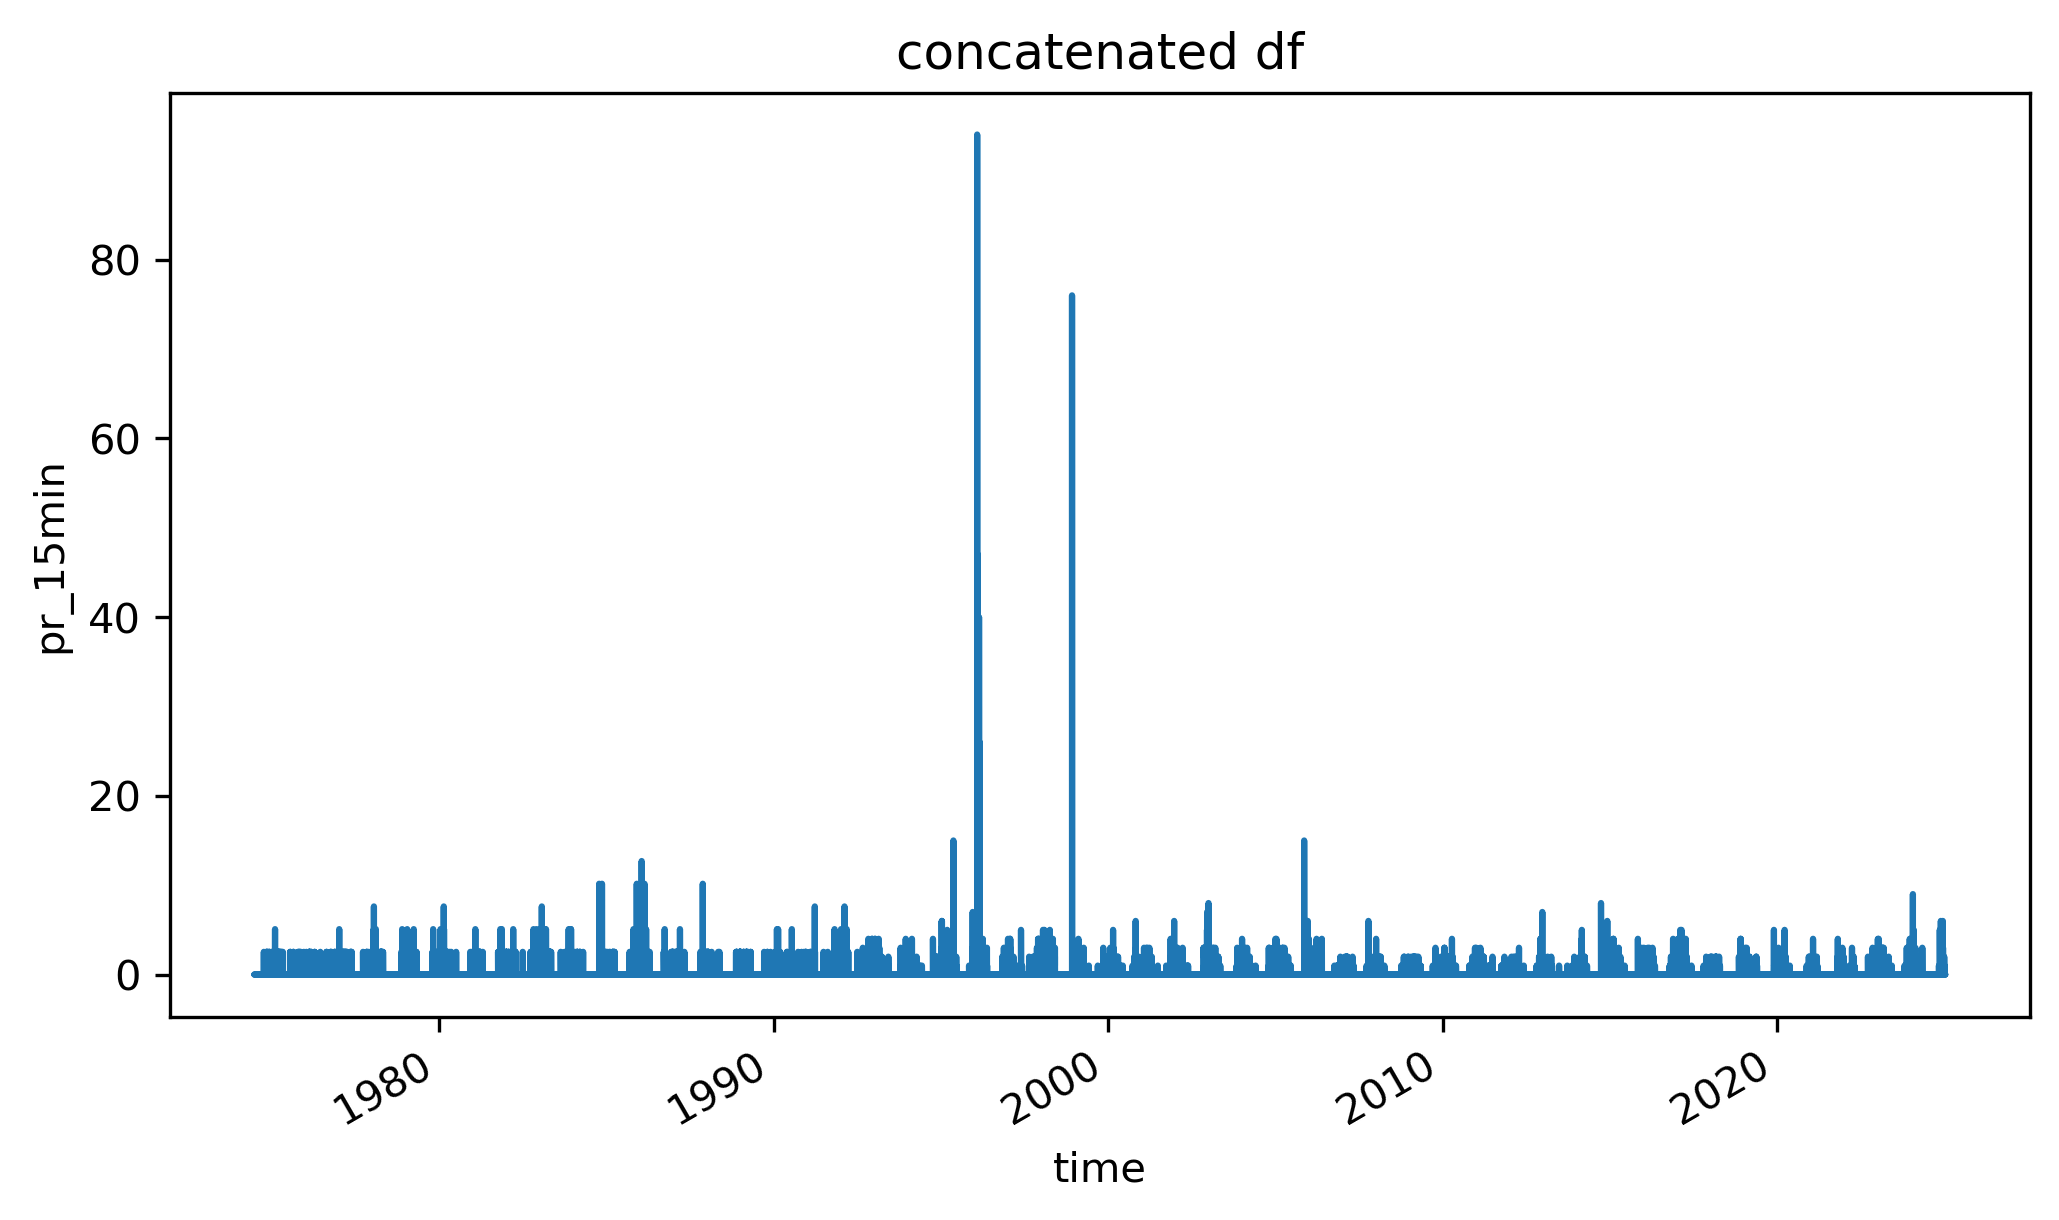

In [104]:
plot_this(df_concat)

Text(0, 0.5, 'pr_15min')

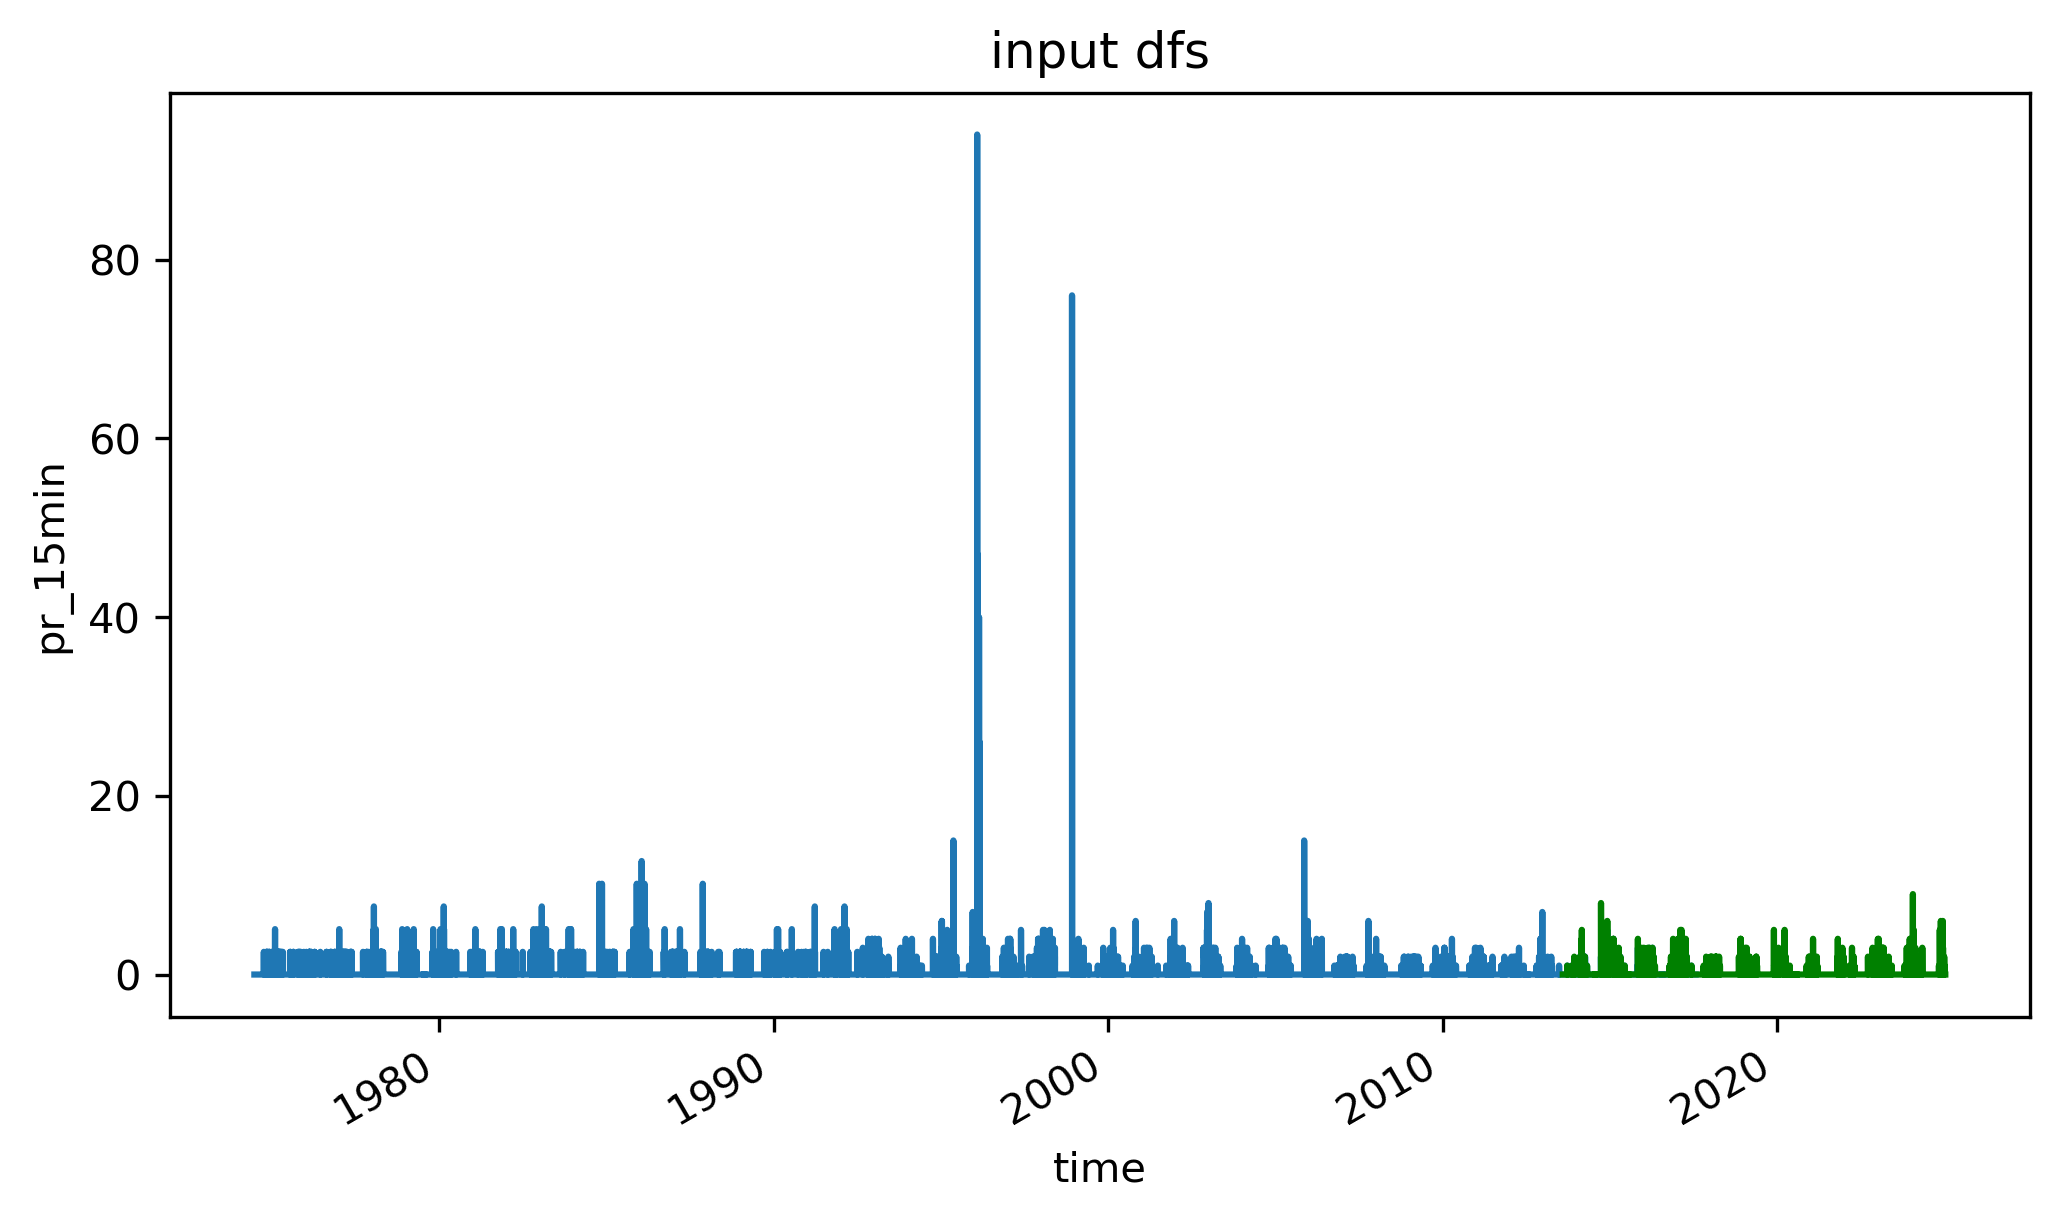

In [105]:
# Create a figure with a specific size
plt.figure(figsize=(8, 4))  

# Plotting the time series of given dataframe
plt.plot(df_old["time"], df_old["pr_15min"])
plt.plot(df_new["time"], df_new["pr_15min"],color='green')

# Giving title to the chart using plt.title
plt.title("input dfs")

# rotating the x-axis tick labels at 30degree
# towards right
plt.xticks(rotation=30, ha="right")

# Providing x and y label to the chart
plt.xlabel("time")
plt.ylabel("pr_15min")

In [169]:
network_list = s3_cl.get_object(
    Bucket=bucket,
    Key="3_qaqc_wx/{}_copy/{}/{}_concat_list_TEST.csv".format(
        network_name, network_name, network_name
    ),
)
concat_list = pd.read_csv(BytesIO(network_list["Body"].read()))

In [170]:
station_1 = concat_list["ERA-ID"].iloc[0]
station_2 = concat_list["ERA-ID"].iloc[1]

# import this subset of datasets and convert to dataframe
url_1 = "s3://wecc-historical-wx/3_qaqc_wx/{}/{}.zarr".format(
    network_name, station_1
)
url_2 = "s3://wecc-historical-wx/3_qaqc_wx/{}/{}.zarr".format(
    network_name, station_2
)

ds_1 = xr.open_zarr(url_1)
ds_2 = xr.open_zarr(url_2)

df_1 = ds_1.to_dataframe()
df_2 = ds_2.to_dataframe()

df_1 = df_1.reset_index(level="time")
df_2 = df_2.reset_index(level="time")

In [171]:
# import this subset of datasets and convert to dataframe
url_output = "s3://wecc-historical-wx/3_qaqc_wx/{}/test_concat_{}.zarr".format(
    network_name, network_name
)

# TODO: open_zarr will be used for QAQC'd datasets
ds_output = xr.open_zarr(url_output)

df_output = ds_output.to_dataframe()

df_output = df_output.reset_index(level="time")

Plot the two original datasets

Plot the output dataset

### Previous Approaches

In [ ]:
def concat_test(concat_list):
    """
    Performs concatenation for stations in list of stations flagged for concatenation.

    Rules
    ------
        1.) concatenation: keep the newer station data in the time range in which both stations overlap
    Parameters
    ------
        network_name: string
            weather station network
        station_old: string
            name of the older weather station
        station_new: string
            name of the newer weather station
    Returns
    -------
        if success:
            all processed datasets are exported to the merge folder in AWS and the original datasets are deleted
        if failure:
            None
    """
    ##### Import target datasets and convert to dataframe
    flag_range = list(
        range(concat_list["concat_flag"].min(), concat_list["concat_flag"].max())
    )

    for i in flag_range:
        subset_list = concat_list[concat_list["concat_flag"] == i]
        subset_range = list(range(0, len(subset_list)))

        url = {}
        ds = {}
        df = {}

        for i in subset_range:

            # extract information needed for dataset import
            row_i = subset_list.iloc[[i]]
            network_name = row_i["ERA-ID"].split("_")[
                0
            ]  # TODO: this does not work, when it really should
            station_name = row_i["ERA-ID"]

            url[i] = "s3://wecc-historical-wx/3_qaqc_wx/{}/{}_{}.zarr".format(
                network_name, network_name, station_name
            )

            ds[i] = xr.open_zarr(url[i])

            df[i] = ds[i].to_dataframe()

            # Apply reset index only to 'time', as we will need that for concatenation
            df[i] = df[i].reset_index(level="time")

    ##### Split datframes into subsets #####

    # Remove data in time overlap between old and new
    df_old_cleaned = df_old[~df_old["time"].isin(df_new["time"])]
    df_new_cleaned = df_new[~df_new["time"].isin(df_old["time"])]

    # Data in new input that overlaps in time with old input
    df_overlap = df_new[df_new["time"].isin(df_old["time"])]

    # Set index to new input for df_old_cleaned
    # We want the final dataset to show up as the new station, not the old
    final_station_name = "{}_{}".format(network_name, station_new)
    new_index = [final_station_name] * len(df_old_cleaned)

    df_old_cleaned.index = new_index
    df_old_cleaned.index.name = "station"

    ##### Concatenate subsets #####

    df_concat = concat([df_old_cleaned, df_overlap, df_new_cleaned])

    # Add 'time' back into multi index
    df_concat.set_index("time", append=True, inplace=True)

    # Convert concatenated dataframe to dataset
    ds_concat = df_concat.to_xarray()

    ##### Update attributes and datatypes #####

    # Include past attributes
    ds_concat.attrs = ds_new.attrs

    # Update 'history' attribute
    timestamp = datetime.datetime.utcnow().strftime("%m-%d-%Y, %H:%M:%S")
    ds_concat.attrs["history"] = ds_new.attrs[
        "history"
    ] + " \nmaritime_merge.ipynb run on {} UTC".format(timestamp)

    # Update 'comment' attribute
    ds_concat.attrs["comment"] = (
        "Final v1 data product. This data has been subjected to cleaning, QA/QC, and standardization."
    )

    # Add new qaqc_files_merged attribute
    ds_concat.attrs["qaqc_files_merged"] = (
        "{}_{}, {}_{} merged. Overlap retained from newer station data.".format(
            network_name, station_old, network_name, station_new
        )
    )

    # Convert all datatypes, to enable export
    existing_float32 = [col for col in float32_variables if col in df_concat.columns]
    existing_U16 = [col for col in U16_variables if col in df_concat.columns]

    ds_concat[existing_float32] = ds_concat[existing_float32].astype("float32")
    ds_concat[existing_U16] = ds_concat[existing_U16].astype("U16")

    ds_concat.coords["station"] = ds_concat.coords["station"].astype("<U16")

    ### Export ###

    # delete old inputs
    bucket = "wecc-historical-wx"
    key_new = "4_merge_wx/{}_dev/{}_{}.zarr".format(
        network_name, network_name, station_new
    )
    key_old = "4_merge_wx/{}_dev/{}_{}.zarr".format(
        network_name, network_name, station_old
    )

    delete_folder(bucket, key_new)
    delete_folder(bucket, key_old)

    # Export final, concatenated dataset
    export_url = "s3://wecc-historical-wx/4_merge_wx/{}_dev/{}_{}.zarr".format(
        network_name, network_name, "test"
    )
    ds_concat.to_zarr(export_url, mode="w")

    return None  # ds_concat

## CODE SCRAPS

In [ ]:
test = asosawos_list_concat.groupby(["ICAO"]).apply(
    lambda x: x.sort_values(["end_time"])
)

In [ ]:
# # sort by end_time or end-date, depending on the station TODO: this is not necessary
# time_var_list = ['end_time','end-date']
# end_time_or_date = [col for col in station_list.columns if col in time_var_list]
# new_station_list = new_station_list.groupby('concat_flag').apply(lambda x: x.sort_values(end_time_or_date)).reset_index(drop=True)

In [ ]:
def concatenate_target_stations_old(df):
    """
    Concatenates station data that has been flagged for concatenation

    Rules
    ------
        1.)

    Parameters
    ------
        df: pd.dataframe
            staton data

    Returns
    -------
        if success:
            all processed datasets are exported to the merge folder in AWS and the original datasets are deleted
        if failure:
            None
    """

    # Apply reset index only to 'time', as we will need that for concatenation
    df_old = df_old.reset_index(level="time")
    df_new = df_new.reset_index(level="time")

    ##### Split datframes into subsets #####
    # if there is overlap, then create subsets

    # if no overlap, just concatenate

    # Remove data in time overlap between old and new
    df_old_cleaned = df_old[~df_old["time"].isin(df_new["time"])]
    df_new_cleaned = df_new[~df_new["time"].isin(df_old["time"])]

    # Data in new input that overlaps in time with old input
    df_overlap = df_new[df_new["time"].isin(df_old["time"])]

    # Set index to new input for df_old_cleaned
    # We want the final dataset to show up as the new station, not the old
    final_station_name = "{}_{}".format(network_name, station_new)
    new_index = [final_station_name] * len(df_old_cleaned)

    df_old_cleaned.index = new_index
    df_old_cleaned.index.name = "station"

    ##### Concatenate subsets #####

    df_concat = concat([df_old_cleaned, df_overlap, df_new_cleaned])

    # Add 'time' back into multi index
    df_concat.set_index("time", append=True, inplace=True)

    # Convert concatenated dataframe to dataset
    ds_concat = df_concat.to_xarray()

    ##### Update attributes and datatypes #####

    # Include past attributes
    ds_concat.attrs = ds_new.attrs

    # Update 'history' attribute
    timestamp = datetime.datetime.utcnow().strftime("%m-%d-%Y, %H:%M:%S")
    ds_concat.attrs["history"] = ds_new.attrs[
        "history"
    ] + " \nmaritime_merge.ipynb run on {} UTC".format(timestamp)

    # Update 'comment' attribute
    ds_concat.attrs["comment"] = (
        "Final v1 data product. This data has been subjected to cleaning, QA/QC, and standardization."
    )

    # Add new qaqc_files_merged attribute
    ds_concat.attrs["qaqc_files_merged"] = (
        "{}_{}, {}_{} merged. Overlap retained from newer station data.".format(
            network_name, station_old, network_name, station_new
        )
    )

    # Convert all datatypes, to enable export
    existing_float32 = [col for col in float32_variables if col in df_concat.columns]
    existing_U16 = [col for col in U16_variables if col in df_concat.columns]

    ds_concat[existing_float32] = ds_concat[existing_float32].astype("float32")
    ds_concat[existing_U16] = ds_concat[existing_U16].astype("U16")

    ds_concat.coords["station"] = ds_concat.coords["station"].astype("<U16")

    return None  # ds_concat

In [ ]:
def reorder_station_list(station_list, concat_list, duplicate_list):
    """
    Reorders the input station list, necessary for concatenation

    Rules
    ------
        1.)

    Parameters
    ------
        station_list: pd.dataframe

        concat_list: pd.dataframe

        duplicate_list: pd.dataframe

    Returns
    -------
        if success:
            output station list with stations to be concatenated at top, followed by potential duplicates
        if failure:
            None
    """

    ##### subsets of station list

    # stations that will be concatenated
    concat_stations = station_list[station_list["ICAO"].isin(concat_list)]

    # potential duplicate stations
    duplicate_stations = station_list[station_list["ICAO"].isin(duplicate_list)]

    # all remaining stations
    remaining_stations = station_list[
        ~station_list["ICAO"].isin(duplicate_list + concat_list)
    ]

    ##### sort concat list alphabetically, to ensure that stations with the same ICAO are grouped together
    concat_stations = concat_stations.sort_values("ICAO")
    duplicate_stations = duplicate_stations.sort_values("ICAO")

    ##### now within each ICAO, order by end time
    concat_stations = concat_stations.groupby(["ICAO"]).apply(
        lambda x: x.sort_values(["end_time"])
    )

    ##### concatenate susbets and reset index
    new_list = concat(
        [concat_stations, duplicate_stations, remaining_stations]
    ).reset_index(drop=True)

    return new_list

In [ ]:
# check for presence of start and end times

time_check = repeat_list_subset.groupby("ICAO").apply(lambda x: x.isnull().any())

print("number of null start times:")
print(time_check["start_time"].sum())

print("number of null end times:")
print(time_check["end_time"].sum())

In [ ]:
# check if the start and end times are identical

start_duplicate_check = (
    repeat_list_subset.groupby("ICAO")
    .apply(lambda x: x.duplicated(subset=["start_time"]))
    .rename("check")
    .reset_index()
)
end_duplicate_check = (
    repeat_list_subset.groupby("ICAO")
    .apply(lambda x: x.duplicated(subset=["end_time"]))
    .rename("check")
    .reset_index()
)

In [ ]:
end_list = end_duplicate_check[end_duplicate_check["check"] == True]["ICAO"].tolist()
start_list = start_duplicate_check[start_duplicate_check["check"] == True][
    "ICAO"
].tolist()

print(end_list)
print(start_list)

In [ ]:
# what is going on with the stations that have duplicate start and end times? are they true duplicates?

repeat_list_subset[repeat_list_subset["ICAO"].isin(start_list + end_list)]

In [ ]:
# load in single dc file from AWS
ds_1 = read_nc_from_s3_clean("ASOSAWOS", "ASOSAWOS_72026294076", temp_dir)
ds_2 = read_nc_from_s3_clean("ASOSAWOS", "ASOSAWOS_A0000594076", temp_dir)


# convert to formatted pandas dataframe
df_1 = qaqc_ds_to_df(ds_1, verbose=False)
df_2 = qaqc_ds_to_df(ds_2, verbose=False)

In [ ]:
lon = df_1.lon.mean()
lat = df_1.lat.mean()
# print("{}, {:.5f}, {:.5f}".format(id, lon, lat))


# Plot time series of the data
fig, ax = plt.subplots(figsize=(9, 3))

df_1.plot(ax=ax, x="time", y="sfcWind")
df_2.plot(ax=ax, x="time", y="sfcWind")

ax.set_title("{}  ({:.3f}, {:.3f})".format(id, lon, lat))

In [ ]:
def matching_check_old(station_list):
    """
    Resamples meteorological variables to hourly timestep according to standard conventions.

    Rules
    ------
        1.)

    Parameters
    ------
        df: pd.DataFrame
            list of station information

    Returns
    -------
        if success:
            list
                list of ICAO values of stations that need to be concatenated
            list
                list of ICAO values of potential duplicate stations
        if failure:
            None
    """
    # Generate list of repeat ICAOs
    repeat_list = station_list[station_list.duplicated(subset=["ICAO"], keep=False)]
    repeat_list = repeat_list[
        ["ICAO", "ERA-ID", "STATION NAME", "start_time", "end_time"]
    ]

    concat_list = repeat_list["ICAO"].unique().tolist()

    # And empty list to add potential duplicates to
    duplicate_list = []

    ##### Generate boolean for whether or not there are null start and/or end times
    # TODO: may not be necessary
    time_check = repeat_list.groupby("ICAO").apply(lambda x: x.isnull().any())

    end_nan_list = time_check[time_check["end_time"] == True]["ICAO"].tolist()
    start_nan_list = time_check[time_check["start_time"] == True]["ICAO"].tolist()

    # add ICAOs of stations with nan start or end times to potential duplicates list
    duplicate_list = duplicate_list + start_nan_list + end_nan_list

    duplicate_list = duplicate_list

    ##### Identify ICAOs with duplicate start end times
    start_duplicate_check = (
        repeat_list.groupby("ICAO")
        .apply(lambda x: x.duplicated(subset=["start_time"]))
        .rename("check")
        .reset_index()
    )
    end_duplicate_check = (
        repeat_list.groupby("ICAO")
        .apply(lambda x: x.duplicated(subset=["end_time"]))
        .rename("check")
        .reset_index()
    )

    end_dup_list = end_duplicate_check[end_duplicate_check["check"] == True][
        "ICAO"
    ].tolist()
    start_dup_list = start_duplicate_check[start_duplicate_check["check"] == True][
        "ICAO"
    ].tolist()

    # add ICAOs of stations with nan start or end times to potential duplicates list
    duplicate_list = duplicate_list + start_dup_list + end_dup_list

    # Generate final list of ICAOs for stations to be concatenated
    concat_list = [x for x in concat_list if x not in duplicate_list]

    return concat_list, duplicate_list

In [ ]:
# order the subset with only stations to concatenate

asosawos_list_concat["ICAO"] = pd.Categorical(
    asosawos_list_concat["ICAO"], categories=concat_list, ordered=True
)

test_list = asosawos_list_concat.sort_values("ICAO").reset_index(drop=True)

### Stations within a certain distance

In [ ]:
# Convert the data into GeoDataFrames
# using EPSG 3310

gdf_asosawos = gpd.GeoDataFrame(
    asosawos_list,
    geometry=[
        Point(lon, lat) for lon, lat in zip(asosawos_list["LON"], asosawos_list["LAT"])
    ],
    crs="EPSG:4326",
).to_crs(epsg=3310)

#### approach 3: find the nearest point in the geodataframe

In [ ]:
# insert emtpy columns

gdf_asosawos["nearest_station"] = pd.Series(dtype="U16")
gdf_asosawos["distance"] = pd.Series(dtype="float32")

In [ ]:
for index, row in gdf_asosawos.iterrows():
    # geometry of individual row 
    point = row.geometry
    # returns a multipoint object with the geometries of every row in the gdf
    multipoint = gdf_asosawos.drop(index, axis=0).geometry.unary_union
    # 
    queried_geom, nearest_geom = nearest_points(point, multipoint)
    dist_from_point = 
    gdf_asosawos.loc[index, 'nearest_geometry'] = nearest_geom
    gdf_asosawos.loc[index, 'distance'] = nearest_geom

#### approach 2: distance function

In [ ]:
## function to calculate the distance between points


def distance_sort_filter(row, df2, buffer=None, id=False):

    dist = df2.geometry.distance(row).sort_values()

    if buffer:
        dist = dist[dist < buffer]

    if id:
        distances = {
            df2.loc[idx]["WBAN"]: value for idx, value in zip(dist.index, dist.values)
        }
    else:
        distances = {idx: value for idx, value in zip(dist.index, dist.values)}

    return distances

#### approach 1: using sjoin

In [ ]:
# Create a buffer around points in gdf1 (e.g., 10 km buffer)
gdf_asosawos["buffer"] = gdf_asosawos.geometry.buffer(
    0.1
)  # Buffer in degrees, 0.1 degrees approx equals 10 km

In [ ]:
# Perform a spatial join using the buffer
merged = gpd.sjoin(
    gdf_asosawos, gdf_asosawos[["geometry", "buffer"]], how="inner", predicate="within"
)

# The 'merged' GeoDataFrame contains points from gdf_isd that are within the buffer around points in gdf_asosawos

In [ ]:
print(
    merged
)  # there are not ISD stations within 10km of an ASOSAWOS station missed by the exact matching

In [ ]:
### Round asosawos down to 3 decimal points of accuracy
# asosawos_round = asosawos_list.round({"LAT": 3, "LON": 3})

Potential ways to check that two stations are duplicates
1. identical total_nobs
2. identical ERA IDs
3. identical end or start times 

In [ ]:
# Extract flagged stations

asosawos_dup = asosawos_out[~asosawos_out["concat_flag"].isna()]
valleywater_dup = valleywater_out[~valleywater_out["concat_flag"].isna()]
maritime_dup = maritime_out[~maritime_out["concat_flag"].isna()]

### Final Function

In [ ]:
def duplicate_check(station_list):
    """
    This function flags stations that are potentially duplicates

    Rules
    ------
        1.) Within stations flagged for concatenation, stations are flagged as potential duplicates
            if either their start or end times are identical
            - TODO: brainstorm alternative approaches

    Parameters
    ------
        station_list: pd.DataFrame
            list of station information that has passed through the concatenation check

    Returns
    -------
        if success:
            new_station_list: pd.DataFrame


        if failure:
            None
    Notes
    -------

    """
    ##### flag stations with repeat end or start times

    time_end_list = ["end_time", "end-date"]
    time_start_list = ["start_time", "start-date"]

    end_time_or_date = [col for col in station_list.columns if col in time_var_list]

    new_station_list = (
        new_station_list.groupby("concat_flag")
        .apply(lambda x: x.sort_values(end_time_or_date))
        .reset_index(drop=True)
    )

    return new_station_list

In [ ]:
def concatenate_target_stations_old(network_name, station_old, station_new):
    """
    Concatenates two input datasets, deletes the originals, and exports the final concatenated dataset

    Rules
    ------
        1.) concatenation: keep the newer station data in the time range in which both stations overlap

    Parameters
    ------
        network_name: string
            weather station network
        station_old: string
            name of the older weather station
        station_new: string
            name of the newer weather station

    Returns
    -------
        if success:
            all processed datasets are exported to the merge folder in AWS and the original datasets are deleted
        if failure:
            None
    """
    # Import target datasets and convert to dataframe
    old_url = "s3://wecc-historical-wx/4_merge_wx/{}_dev/{}_{}.zarr".format(
        network_name, network_name, station_old
    )
    new_url = "s3://wecc-historical-wx/4_merge_wx/{}_dev/{}_{}.zarr".format(
        network_name, network_name, station_new
    )

    ds_old = xr.open_zarr(old_url)
    ds_new = xr.open_zarr(new_url)

    df_old = ds_old.to_dataframe()
    df_new = ds_new.to_dataframe()

    # Apply reset index only to 'time', as we will need that for concatenation
    df_old = df_old.reset_index(level="time")
    df_new = df_new.reset_index(level="time")

    ##### Split datframes into subsets #####

    # Remove data in time overlap between old and new
    df_old_cleaned = df_old[~df_old["time"].isin(df_new["time"])]
    df_new_cleaned = df_new[~df_new["time"].isin(df_old["time"])]

    # Data in new input that overlaps in time with old input
    df_overlap = df_new[df_new["time"].isin(df_old["time"])]

    # Set index to new input for df_old_cleaned
    # We want the final dataset to show up as the new station, not the old
    final_station_name = "{}_{}".format(network_name, station_new)
    new_index = [final_station_name] * len(df_old_cleaned)

    df_old_cleaned.index = new_index
    df_old_cleaned.index.name = "station"

    ##### Concatenate subsets #####

    df_concat = concat([df_old_cleaned, df_overlap, df_new_cleaned])

    # Add 'time' back into multi index
    df_concat.set_index("time", append=True, inplace=True)

    # Convert concatenated dataframe to dataset
    ds_concat = df_concat.to_xarray()

    ##### Update attributes and datatypes #####

    # Include past attributes
    ds_concat.attrs = ds_new.attrs

    # Update 'history' attribute
    timestamp = datetime.datetime.utcnow().strftime("%m-%d-%Y, %H:%M:%S")
    ds_concat.attrs["history"] = ds_new.attrs[
        "history"
    ] + " \nmaritime_merge.ipynb run on {} UTC".format(timestamp)

    # Update 'comment' attribute
    ds_concat.attrs["comment"] = (
        "Final v1 data product. This data has been subjected to cleaning, QA/QC, and standardization."
    )

    # Add new qaqc_files_merged attribute
    ds_concat.attrs["qaqc_files_merged"] = (
        "{}_{}, {}_{} merged. Overlap retained from newer station data.".format(
            network_name, station_old, network_name, station_new
        )
    )

    # Convert all datatypes, to enable export
    existing_float32 = [col for col in float32_variables if col in df_concat.columns]
    existing_U16 = [col for col in U16_variables if col in df_concat.columns]

    ds_concat[existing_float32] = ds_concat[existing_float32].astype("float32")
    ds_concat[existing_U16] = ds_concat[existing_U16].astype("U16")

    ds_concat.coords["station"] = ds_concat.coords["station"].astype("<U16")

    ### Export ###

    # delete old inputs
    bucket = "wecc-historical-wx"
    key_new = "4_merge_wx/{}_dev/{}_{}.zarr".format(
        network_name, network_name, station_new
    )
    key_old = "4_merge_wx/{}_dev/{}_{}.zarr".format(
        network_name, network_name, station_old
    )

    delete_folder(bucket, key_new)
    delete_folder(bucket, key_old)

    # Export final, concatenated dataset
    export_url = "s3://wecc-historical-wx/4_merge_wx/{}_dev/{}_{}.zarr".format(
        network_name, network_name, "test"
    )
    ds_concat.to_zarr(export_url, mode="w")

    return None  # ds_concat